In [41]:
import pandas as pd
import os
# from multiprocess import Pool
import numpy as np
import math
from sklearn.base import BaseEstimator, TransformerMixin
from glob import glob
import gensim.downloader as api
from nltk.tokenize import TweetTokenizer
from sklearn.decomposition import PCA
import wordninja
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Grab the tokenizer
tokenizer = TweetTokenizer()
# Download the glove model
glove_model = api.load("glove-twitter-25")
# Select the files
files = glob("lending_club_data/*.zip")

In [43]:
def read_one(path):
    # Read one csv
    return pd.read_csv(path, low_memory=False, skiprows=1, compression="zip")


def create_combined_dataset(files):
    # Read all csvs
    data = [read_one(f"{file}") for file in files if file.endswith(".zip")]
    return pd.concat(data)


def build_dataset(files):
    # Get these features

    features = [
        "title",
        "emp_title",
        "loan_amnt",
        "term",
        "int_rate",
        "installment",
        "grade",
        "sub_grade",
        "emp_length",
        "home_ownership",
        "annual_inc",
        "verification_status",
        "purpose",
        "addr_state",
        "dti",
        "delinq_2yrs",
        "earliest_cr_line",
        "fico_range_low",
        "fico_range_high",
        "inq_last_6mths",
        "mths_since_last_delinq",
        "mths_since_last_record",
        "open_acc",
        "pub_rec",
        "revol_bal",
        "revol_util",
        "total_acc",
        "initial_list_status",
        "loan_status",
    ]
    df = create_combined_dataset(files)
    # Ensure loan status is valid
    status_list = ["Fully Paid", "Charged Off", "Late (31-120 days)", "Default"]

    df = df[df["loan_status"].isin(status_list)]
    # Convert loan status to numeric
    df["loan_status"] = df["loan_status"].apply(make_target)

    # Remove non-strings from title
    mask = [isinstance(item, (str, bytes)) for item in df["title"]]
    df = df.loc[mask]

    # Remove non-strings from emp_title
    mask = [isinstance(item, (str, bytes)) for item in df["emp_title"]]
    df = df.loc[mask]

    print(df.head())
    return df[features]


def make_target(val):
    # Convert to int()
    return int(val in ["Charged Off", "Late (31-120 days)", "Default"])

In [44]:
df = build_dataset(files)

           id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
7   164193225        NaN     7500.0       7500.0           7500.0   36 months   
45  164190449        NaN    15000.0      15000.0          15000.0   60 months   
55  164173227        NaN    10500.0      10500.0          10500.0   36 months   
61  164168053        NaN    35000.0      35000.0          34975.0   60 months   
67  164178130        NaN    33000.0      33000.0          32975.0   60 months   

   int_rate  installment grade sub_grade  ...  \
7    12.40%       250.55     B        B4  ...   
45   23.05%       423.29     D        D3  ...   
55   25.65%       421.10     D        D4  ...   
61   18.62%       900.62     D        D1  ...   
67   13.08%       752.21     B        B5  ...   

   orig_projected_additional_accrued_interest hardship_payoff_balance_amount  \
7                                         NaN                            NaN   
45                                        NaN             

In [45]:
df

title                                emp_title  \
7       Credit card refinancing                                       Rn   
45      Credit card refinancing                            Social Worker   
55           Debt consolidation  Commercial Security Account Consultant    
61           Debt consolidation                          General Manager   
67      Credit card refinancing                               CLAIMS REP   
...                         ...                                      ...   
130763       Debt consolidation                               Production   
130764  Credit card refinancing                        Machine operator    
130766       Debt consolidation    Direct Service Provider Day Activity    
130768                    Other                                  Cleaner   
130771       Debt consolidation                                  Founder   

        loan_amnt        term int_rate  installment grade sub_grade  \
7          7500.0   36 months   12.40%       250.55     B        B4   
45        15000.0   60 months   23.05%       423.29     D        D3   
55        10500.0   36 months   25.65%       421.10     D        D4   
61        35000.0   60 months   18.62%       900.62     D        D1   
67        33000.0   60 months   13.08%       752.21     B        B5   
...           ...         ...      ...          ...   ...       ...   
130763     5000.0   36 months   13.58%       169.87     C        C2   
130764    15000.0   60 months   16.01%       364.86     C        C5   
130766     6800.0   36 months   16.01%       239.11     C        C5   
130768     3000.0   36 months   20.39%       112.09     D        D4   
130771    35000.0   36 months    6.07%      1065.88     A        A2   

       emp_length home_ownership  ...  inq_last_6mths mths_since_last_delinq  \
7         7 years           RENT  ...             1.0                   27.0   
45        7 years       MORTGAGE  ...             0.0                   18.0   
55         1 year       MORTGAGE  ...             0.0                    NaN   
61      10+ years           RENT  ...             0.0                    NaN   
67      10+ years           RENT  ...             0.0                   60.0   
...           ...            ...  ...             ...                    ...   
130763    8 years       MORTGAGE  ...             0.0                   13.0   
130764  10+ years       MORTGAGE  ...             0.0                   80.0   
130766  10+ years       MORTGAGE  ...             0.0                   15.0   
130768  10+ years           RENT  ...             0.0                    NaN   
130771  10+ years           RENT  ...             0.0                    NaN   

       mths_since_last_record open_acc  pub_rec  revol_bal revol_util  \
7                         NaN     18.0      0.0    16195.0      30.7%   
45                        NaN      5.0      0.0    14275.0      69.6%   
55                      113.0     12.0      1.0    38114.0      65.3%   
61                        NaN     25.0      0.0    44048.0      43.5%   
67                        NaN      3.0      0.0      593.0       3.2%   
...                       ...      ...      ...        ...        ...   
130763                    NaN      8.0      0.0     4833.0      24.4%   
130764                    NaN     25.0      0.0    13410.0      23.9%   
130766                    NaN      7.0      0.0     3244.0      28.7%   
130768                    NaN     11.0      0.0     5509.0      60.5%   
130771                    NaN     13.0      0.0    39634.0      35.2%   

        total_acc  initial_list_status  loan_status  
7            34.0                    w            0  
45           54.0                    w            0  
55           22.0                    f            0  
61           30.0                    f            1  
67           19.0                    f            0  
...           ...                  ...          ...  
130763       22.0                    w      

In [46]:
# Custom Transforms
class fix_percent(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        _X = X.copy()

        for i in X.columns:
            _X[i] = _X[i].str.replace("%", "").astype(float) / 100
        return _X

In [51]:
class vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # These are valid singleton values
        self.SINGLES = {"other", "vacation", "business", "consolidate"}
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        _X = X.copy()
        to_return = []

        for i in X.columns:
            # For each column, transform
            vector_col = _X[i].apply(self.get_vectors)
            _X = pd.concat([_X, vector_col.apply(pd.Series)], axis = 1).drop(i, axis = 1)
 
        return _X

    def get_vectors(self, input_string):
        """Get the sum of the word vectors... Also, try to clean up some stuff"""
        # Empty array
        final_vector = np.zeros(25)
        # Tokenize the words in the input
        words = tokenizer.tokenize(input_string)
        # If there's only one word, something went wrong with the tokenizer
        if len(words) == 1 and words[0].lower() not in self.SINGLES:
            # Try to split with non-text characters
            words = re.split(r"[\W_]+", words[0])
            # print(words)
            if len(words) == 1:
                # Try to split on words without spaces
                words = wordninja.split(words[0])

        # Check for spelling errors
        # misspelled = spell.unknown(words)
        # For the words we've found
        for word in words:
            # If the word is misspelled
            # if word in misspelled:
            #     print(f"Fixing {word}")
            #     # Correct it
            #     word = spell.correction(word)
            try:
                # Add the vector from glove to the final_vector
                final_vector += glove_model.word_vec(word.lower())
            except KeyError:
                # print(f"{word.lower()} not valid")
                pass
        # print(f"Added {len(words)}")
        return final_vector

In [116]:
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Features that we want to leave untransformed:
# Only numeric features need apply:
standardize_and_impute_only = [
    "loan_amnt",
    "annual_inc",
    "delinq_2yrs",
    "inq_last_6mths",
    "open_acc",
]


# maybe we will trying some polynomial transofmrations
polynomial_features = ["installment", "dti"]

# how about some discretizations?
discretization = [
    "fico_range_low",
    "fico_range_high",
    "mths_since_last_delinq",
    "mths_since_last_record",
    "pub_rec",
    "revol_bal",
    "total_acc",
]

word_vec = ["title", "emp_title"]

# let's construct all of our transformers
standard_scaler = StandardScaler()
missing_indicator = MissingIndicator(features="all")
simple_imputer = SimpleImputer(strategy="median")
polynomial_featurizer = PolynomialFeatures(2)
discretizer = KBinsDiscretizer(n_bins=8, encode="ordinal", strategy="uniform")
fix_percent_transformer = fix_percent()
word_vectorizer = vectorizer()

# and make the pipelines
standardize_and_impute_pipeline_steps = [
    ("standardization", standard_scaler),
    ("imputer", simple_imputer),
]
standardize_and_impute_pipeline = Pipeline(standardize_and_impute_pipeline_steps)

polynomial_pipeline_steps = standardize_and_impute_pipeline_steps + [
    ("polynomial", polynomial_featurizer)
]
polynomial_pipeline = Pipeline(polynomial_pipeline_steps)

discretize_steps = [("imputer", simple_imputer), ("discretize", discretizer)]
discretize_pipeline = Pipeline(discretize_steps)

interest_rate_steps = [
    ("fix_int_rate", fix_percent_transformer)
] + standardize_and_impute_pipeline_steps
interest_rate_pipeline = Pipeline(interest_rate_steps)

missing_flag_steps = [("missing_flag", missing_indicator)]
missing_flag_pipeline = Pipeline(missing_flag_steps)

word_vectorizer_steps = [("word_vec", word_vectorizer)]
word_vectorizer_pipeline = Pipeline(word_vectorizer_steps)

# now we can use a ColumnTransformer to do everything
transform_pipeline = ColumnTransformer(
    [
        (
            "standardize_and_impute_pipeline",
            standardize_and_impute_pipeline,
            standardize_and_impute_only,
        ),
        ("polynomial_pipeline", polynomial_pipeline, polynomial_features),
        ("discretize_pipeline", discretize_pipeline, discretization),
        ("interest_rate_pipeline", interest_rate_pipeline, ["int_rate"]),
        (
            "missing_flag_pipeline",
            missing_flag_pipeline,
            standardize_and_impute_only + polynomial_features + discretization,
        ),
        ("word_vec", word_vectorizer_pipeline, word_vec),
    ]
)

In [121]:
df_small = df.sample(n=10000)

X = df_small.drop(["loan_status"], axis=1)
y = df_small[["loan_status"]]

from sklearn import ensemble

# best_params = {'rf__max_depth': 8, 'rf__min_samples_leaf': 100}

rf = ensemble.RandomForestClassifier()

pipeline = Pipeline([("transform", transform_pipeline), ("rf", rf)])

In [55]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "rf__max_depth": [1, 2, 3, 4, 5, 6, 7, 8],
    "rf__min_samples_leaf": [5, 50, 100, 500, 1000],
}

gs = GridSearchCV(pipeline, parameters, cv=5, scoring="roc_auc", verbose=3, n_jobs=6)

gs.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed: 12.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('standardize_and_impute_pipeline',
                                                                         Pipeline(steps=[('standardization',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['loan_amnt',
                                                                          'annual_inc',
                                                                          'delinq_2yrs',
                                                                          'inq_last_6mths',
                  

In [122]:
pipeline.fit(X, y)
importance = list(pipeline.steps[-1][1].feature_importances_)

best = max(importance)
print(f"Best: Feature {importance.index(best)}, {best:.4f}")

x_feat = []
labels = []
for i in range(0,50):
    x_feat.append(importance[i])
    if i <25:
        feature = "title"
    else:
        i %= 25
        feature = "emp_title"
    labels.append(f"{i}_{feature}")


Best: Feature 18, 0.0663


In [127]:
x_feat,labels = zip(*sorted(zip(x_feat,labels), key=lambda x: x[0]))

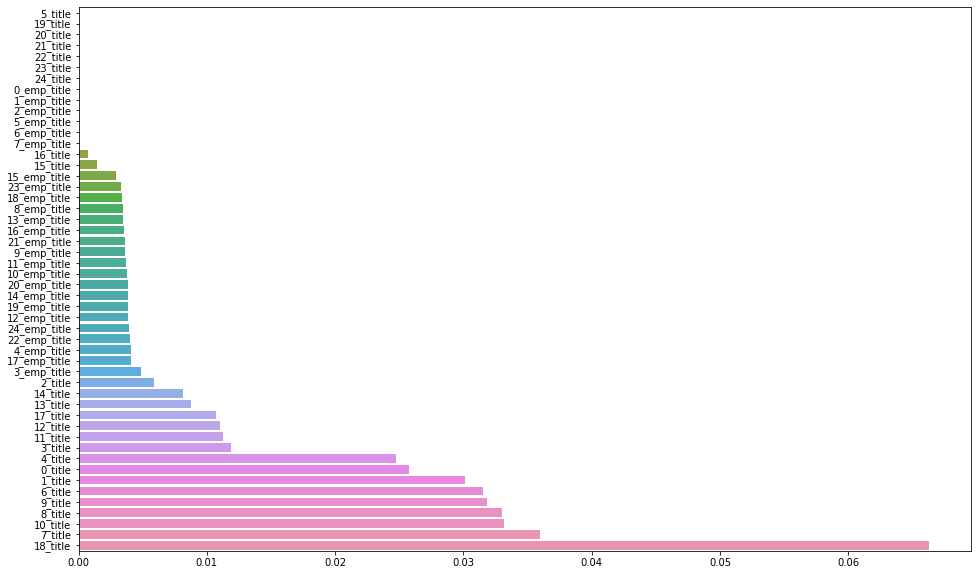

In [126]:
plt.figure(figsize=(16, 10))
sns.barplot(
    x=list(x_feat),
    y=list(labels),
    # x_label="Feature Importance"
)